# Gradient Descent and Stochastic Gradient Descent

This notebook has three main parts:

### Section A — Geometry on the Rosenbrock Function (GD only)
- 2D Rosenbrock function
- 3D surface and contour plots
- Gradient Descent (GD) trajectory

### Section B — True SGD as a Sum over Data Points (Logistic Regression)
- Synthetic 1D logistic regression dataset
- Modular setup: model, loss, full gradient, and per-sample gradient
- GD vs. true SGD (single-sample updates)

### Section C — Large-Data Timing & Algorithm Variants
- Larger logistic dataset
- Compare **batch GD** with:
  - plain SGD (batch size 1, fixed learning rate)
  - mini-batch SGD (batch size $b$)
  - SGD with a decaying learning rate
  - mini-batch SGD with a decaying learning rate
- Use **loss vs wall-clock time** plots to show how SGD-type methods can be more efficient
  when $N$ is large, while also discussing practical timing caveats in pure Python.

Here $\eta_k=$`lr` always denotes the **learning rate**, i.e., the step size in
$$ \theta_{k+1} = \theta_k - \eta_k \, \nabla f(\theta_k). $$

The plotting style uses `classlib.nbviz` when available and falls back to default Matplotlib otherwise.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time
nbviz_available = False
try:
    import classlib as cl
    cl.nbviz.init(use_tex=False)
    nbviz_available = True
    print('Initialized nbviz style from classlib.')
except Exception as e:
    print('classlib.nbviz not available; using default matplotlib style.')
    print('Reason:', e)

np.random.seed(42)

Initialized nbviz style from classlib.


## Section A — Geometry of Gradient Descent on the Rosenbrock Function

The 2D Rosenbrock function is
\begin{align}
f(x, y) = (1 - x)^2 + 100 (y - x^2)^2.
\end{align}

It has a narrow, curved valley and is a classic test problem for optimization algorithms.
Here we use **gradient descent (GD)** to build geometric intuition; we do *not* introduce
stochasticity in this section.

In [3]:
def rosenbrock_2d(x):
    x1, x2 = x
    return (1.0 - x1)**2 + 100.0 * (x2 - x1**2)**2

def grad_rosenbrock_2d(x):
    x1, x2 = x
    dfdx1 = -2.0 * (1.0 - x1) - 400.0 * x1 * (x2 - x1**2)
    dfdx2 = 200.0 * (x2 - x1**2)
    return np.array([dfdx1, dfdx2])

### 3D Surface Plot

We first visualize the Rosenbrock function as a surface to see the characteristic valley.

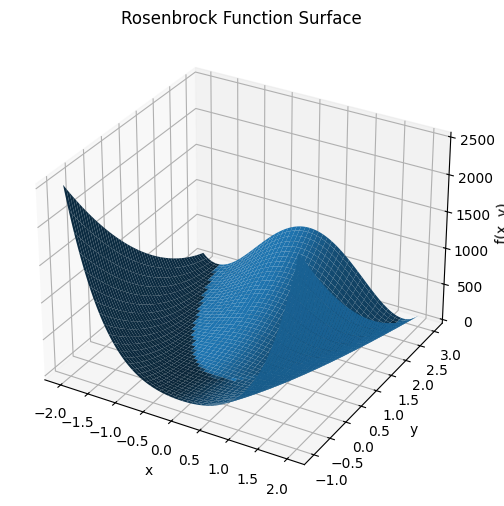

In [4]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

x = np.linspace(-2, 2, 200)
y = np.linspace(-1, 3, 200)
X, Y = np.meshgrid(x, y)
Z = (1.0 - X)**2 + 100.0 * (Y - X**2)**2

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, rstride=4, cstride=4, linewidth=0, antialiased=True)
ax.set_title('Rosenbrock Function Surface')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
plt.show()

if nbviz_available:
    cl.nbviz.savefig('rosenbrock_surface')

### Gradient Descent Trajectory on 2D Rosenbrock

We now run plain gradient descent from a starting point far from the minimum and show
its trajectory on the contour plot, as well as the function value vs iteration.

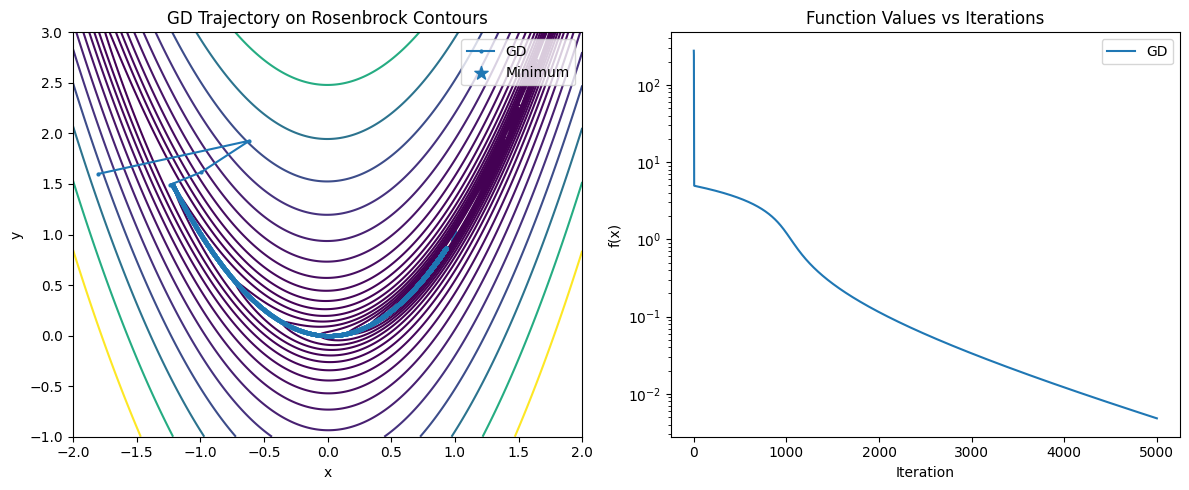

In [5]:
def gradient_descent_2d(x0, lr=1e-3, steps=5000):
    x = np.array(x0, dtype=float)
    path = [x.copy()]
    fvals = [rosenbrock_2d(x)]
    for k in range(steps):
        g = grad_rosenbrock_2d(x)
        x = x - lr * g
        path.append(x.copy())
        fvals.append(rosenbrock_2d(x))
    return np.array(path), np.array(fvals)

x0 = np.array([-1.8, 1.6])
path_gd, fvals_gd = gradient_descent_2d(x0, lr=1e-3, steps=5000)

x = np.linspace(-2, 2, 400)
y = np.linspace(-1, 3, 400)
X, Y = np.meshgrid(x, y)
Z = (1.0 - X)**2 + 100.0 * (Y - X**2)**2

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

ax = axs[0]
cs = ax.contour(X, Y, Z, levels=np.logspace(-1, 3, 20))
ax.plot(path_gd[:, 0], path_gd[:, 1], '-', marker='o', markersize=2, label='GD')
ax.scatter([1.0], [1.0], marker='*', s=100, label='Minimum')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('GD Trajectory on Rosenbrock Contours')
ax.legend()

ax = axs[1]
ax.semilogy(fvals_gd, label='GD')
ax.set_xlabel('Iteration')
ax.set_ylabel('f(x)')
ax.set_title('Function Values vs Iterations')
ax.legend()

plt.tight_layout()
plt.show()

if nbviz_available:
    cl.nbviz.savefig('rosenbrock_gd_only')

## Section B — SGD as a Sum over Data Points (Logistic Regression)

In many machine learning problems, the objective is a sum (or average) of per-data-point
losses:
\begin{align}
L(\theta) = \frac{1}{N} \sum_{i=1}^N \ell_i(\theta).
\end{align}

Gradient descent uses the full gradient $\nabla L(\theta)$, while stochastic
gradient descent (SGD) uses a **single** (or minibatch) term $\nabla \ell_{i_k}(\theta)$.

Here we build a **modular logistic regression example**:
- synthetic 1D data
- logistic model
- negative log-likelihood loss
- functions for full gradient and per-sample gradient, which we can plug into generic GD/SGD solvers.

In [6]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

N = 200
x_data = np.linspace(-3, 3, N)
true_theta = np.array([0.5, -1.0])
p_true = sigmoid(true_theta[0] + true_theta[1] * x_data)
y_data = (np.random.rand(N) < p_true).astype(float)

print(f'{N} data generated with true parameters:', true_theta)

200 data generated with true parameters: [ 0.5 -1. ]


### Logistic Regression: Model, Loss, and Gradients

We define a helper that returns four callables:
- `model(theta, x)` – predicted probability
- `loss(theta)` – average negative log-likelihood
- `grad_full(theta)` – gradient of the loss using all data
- `grad_single(theta, i)` – gradient contribution from a single data point

This makes it easy to swap in another model or loss later.

In [7]:
def make_logistic_problem(x_data, y_data):
    x_data = np.asarray(x_data)
    y_data = np.asarray(y_data)

    def model(theta, x):
        return sigmoid(theta[0] + theta[1] * x)

    def loss(theta):
        z = theta[0] + theta[1] * x_data
        p = sigmoid(z)
        eps = 1e-12
        p = np.clip(p, eps, 1.0 - eps)
        return -np.mean(y_data * np.log(p) + (1.0 - y_data) * np.log(1.0 - p))

    def grad_full(theta):
        z = theta[0] + theta[1] * x_data
        p = sigmoid(z)
        diff = p - y_data
        dtheta0 = np.mean(diff)
        dtheta1 = np.mean(diff * x_data)
        return np.array([dtheta0, dtheta1])

    def grad_single(theta, i):
        z_i = theta[0] + theta[1] * x_data[i]
        p_i = sigmoid(z_i)
        diff = p_i - y_data[i]
        dtheta0 = diff
        dtheta1 = diff * x_data[i]
        return np.array([dtheta0, dtheta1])

    return model, loss, grad_full, grad_single

model, loss, grad_full, grad_single = make_logistic_problem(x_data, y_data)
print('Initial loss at theta = [0, 0]:', loss(np.array([0.0, 0.0])))

Initial loss at theta = [0, 0]: 0.6931471805599452


### Generic Gradient Descent and Stochastic Gradient Descent

We now define generic functions that take gradient and loss callables. This makes it
easy to reuse the same solvers for different models or loss functions.

In [8]:
def run_gd(theta0, grad_full, loss, steps=200, lr=0.1):
    theta = np.array(theta0, dtype=float)
    thetas = [theta.copy()]
    fvals = [loss(theta)]
    for k in range(steps):
        g = grad_full(theta)
        theta = theta - lr * g
        thetas.append(theta.copy())
        fvals.append(loss(theta))
    return np.array(thetas), np.array(fvals)

def run_sgd(theta0, grad_single, loss, n_data, steps=1000, lr=0.1):
    theta = np.array(theta0, dtype=float)
    thetas = [theta.copy()]
    fvals = [loss(theta)]
    for k in range(steps):
        i = np.random.randint(0, n_data)
        g_i = grad_single(theta, i)
        theta = theta - lr * g_i
        thetas.append(theta.copy())
        fvals.append(loss(theta))
    return np.array(thetas), np.array(fvals)

### Run Logistic GD vs SGD and Compare (Small N)

We start from the same initial parameter vector and compare:
- Batch GD using the full gradient.
- True SGD using one randomly chosen data point per step.

On the left we show the data and the fitted logistic curves; on the right we plot the
loss versus iteration. For small $N$, both methods behave similarly, which is expected.

200 data generated with true parameters: [ 0.5 -1. ]
Final GD theta: [ 0.41340207 -0.8967033 ]   loss: 0.48761116971654944
Final SGD theta: [ 0.50781404 -1.11981644]   loss: 0.494194642499037


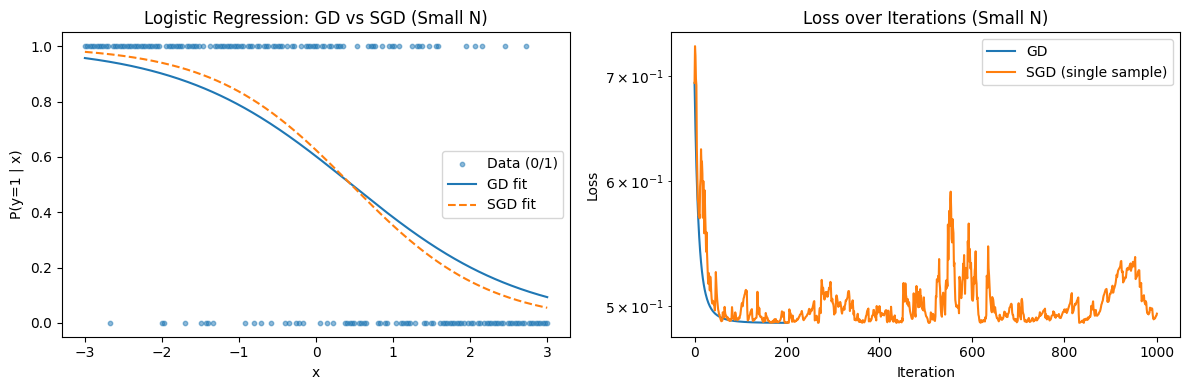

In [9]:
theta_start = np.array([0.0, 0.0])

thetas_gd, fvals_gd = run_gd(theta_start, grad_full, loss, steps=200, lr=0.1)
thetas_sgd, fvals_sgd = run_sgd(theta_start, grad_single, loss, n_data=len(x_data), steps=1000, lr=0.1)

theta_gd = thetas_gd[-1]
theta_sgd = thetas_sgd[-1]

print(f'{N} data generated with true parameters:', true_theta)
print('Final GD theta:', theta_gd, '  loss:', loss(theta_gd))
print('Final SGD theta:', theta_sgd, '  loss:', loss(theta_sgd))

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax0 = axs[0]
ax0.scatter(x_data, y_data, s=10, alpha=0.5, label='Data (0/1)')
x_plot = np.linspace(-3, 3, 400)
ax0.plot(x_plot, model(theta_gd, x_plot), label='GD fit')
ax0.plot(x_plot, model(theta_sgd, x_plot), label='SGD fit', linestyle='--')
ax0.set_xlabel('x')
ax0.set_ylabel('P(y=1 | x)')
ax0.set_title('Logistic Regression: GD vs SGD (Small N)')
ax0.legend()

ax1 = axs[1]
ax1.semilogy(fvals_gd, label='GD')
ax1.semilogy(fvals_sgd, label='SGD (single sample)')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.set_title('Loss over Iterations (Small N)')
ax1.legend()

plt.tight_layout()
plt.show()

if nbviz_available:
    cl.nbviz.savefig('logistic_gd_vs_sgd_smallN')

## Section C — Large-Data Timing & Variants: When Can SGD Be Better?

For small datasets, GD and SGD both run quickly and their behavior can look similar.
The real advantage of SGD appears when the dataset is **large**. Each GD step computes
a full gradient (cost proportional to $N$), whereas SGD and mini-batch SGD use only a
subset of data per step.

In this section we:
- Create a larger logistic regression dataset.
- Compare **batch GD** with
  - plain SGD (batch size 1, fixed learning rate),
  - mini-batch SGD (batch size $b$),
  - SGD with a decaying learning rate,
  - mini-batch SGD with a decaying learning rate.
- Plot **loss vs wall-clock time** for each, always comparing to GD in separate stacked plots.

Because this is pure Python with explicit for-loops, timing reflects both mathematical cost
and Python overhead. In production ML code, most work is vectorized and/or on GPUs, so SGD
usually looks even better per unit time than this toy implementation suggests.

In [10]:
N_big = 200_000
x_big = np.random.uniform(-3, 3, size=N_big)
true_theta_big = np.array([0.5, -1.0])
p_big = sigmoid(true_theta_big[0] + true_theta_big[1] * x_big)
y_big = (np.random.rand(N_big) < p_big).astype(float)

print('Large-N data generated with N =', N_big)
model_big, loss_big, grad_full_big, grad_single_big = make_logistic_problem(x_big, y_big)
print('Initial loss (big) at theta = [0, 0]:', loss_big(np.array([0.0, 0.0])))

Large-N data generated with N = 200000
Initial loss (big) at theta = [0, 0]: 0.6931471805599451


### Timed GD and SGD Variants on Large-N Logistic Regression

We implement versions of GD and SGD that track wall-clock time and loss.

- `run_gd_timed` — full-batch GD
- `run_sgd_timed` — SGD / mini-batch SGD with optional decaying learning rate

We will then create four stacked plots, each comparing GD to **one** variant:
1. GD vs plain SGD (batch size 1, fixed learning rate)
2. GD vs mini-batch SGD (batch size 64, fixed learning rate)
3. GD vs SGD with decaying learning rate (batch size 1)
4. GD vs mini-batch SGD with decaying learning rate (batch size 64)

Here we use a simple decay schedule
$$ \eta_k = \frac{\eta_0}{\sqrt{1 + k/100}}, $$
so the learning rate is large early (fast progress) and shrinks over time (less jitter).

In [11]:
def run_gd_timed(theta0, grad_full, loss, steps=40, lr=0.1):
    """Full-batch GD with wall-clock timing.
    We record loss and time at each iteration.
    """
    theta = np.array(theta0, dtype=float)
    fvals = []
    times = []
    t0 = time.time()
    for k in range(steps):
        fvals.append(loss(theta))
        times.append(time.time() - t0)
        g = grad_full(theta)
        theta = theta - lr * g
    return theta, np.array(times), np.array(fvals)

def run_sgd_timed(theta0, grad_single, loss, n_data,
                   steps=4000, lr=0.05, batch_size=1,
                   decay=False, record_every=40):
    """Timed SGD / mini-batch SGD with optional decaying learning rate.

    Parameters
    ----------
    theta0 : array-like
        Initial parameter vector.
    grad_single : callable
        Function grad_single(theta, i) returning gradient for data point i.
    loss : callable
        Function loss(theta) returning average loss over all data.
    n_data : int
        Number of data points.
    steps : int
        Number of SGD update steps.
    lr : float
        Initial learning rate (step size).
    batch_size : int
        Size of the mini-batch (1 = plain SGD).
    decay : bool
        If True, use lr_k = lr / sqrt(1 + k / 100).
    record_every : int
        Record loss and time every `record_every` steps.
    """
    theta = np.array(theta0, dtype=float)
    fvals = []
    times = []
    t0 = time.time()
    for k in range(steps):
        if k % record_every == 0:
            fvals.append(loss(theta))
            times.append(time.time() - t0)
        if decay:
            lr_k = lr / np.sqrt(1.0 + k / 100.0)
        else:
            lr_k = lr
        idx = np.random.randint(0, n_data, size=batch_size)
        g_batch = np.zeros_like(theta)
        for j in idx:
            g_batch += grad_single(theta, j)
        g_batch /= batch_size
        theta = theta - lr_k * g_batch
    return theta, np.array(times), np.array(fvals)

Final GD (big) theta: [ 0.2130904  -0.78075081]   loss: 0.4722399681113962
Final SGD-1 (big) theta: [ 0.53667255 -0.79260842]   loss: 0.46806141875718543
Final SGD-mini-batch (big) theta: [ 0.49663887 -1.03027045]   loss: 0.460773311499588
Final SGD-decay (big) theta: [ 0.51636033 -0.97427284]   loss: 0.46078069425550616
Final SGD-mini-batcj-decay (big) theta: [ 0.52004451 -1.00374858]   loss: 0.46065652859753403


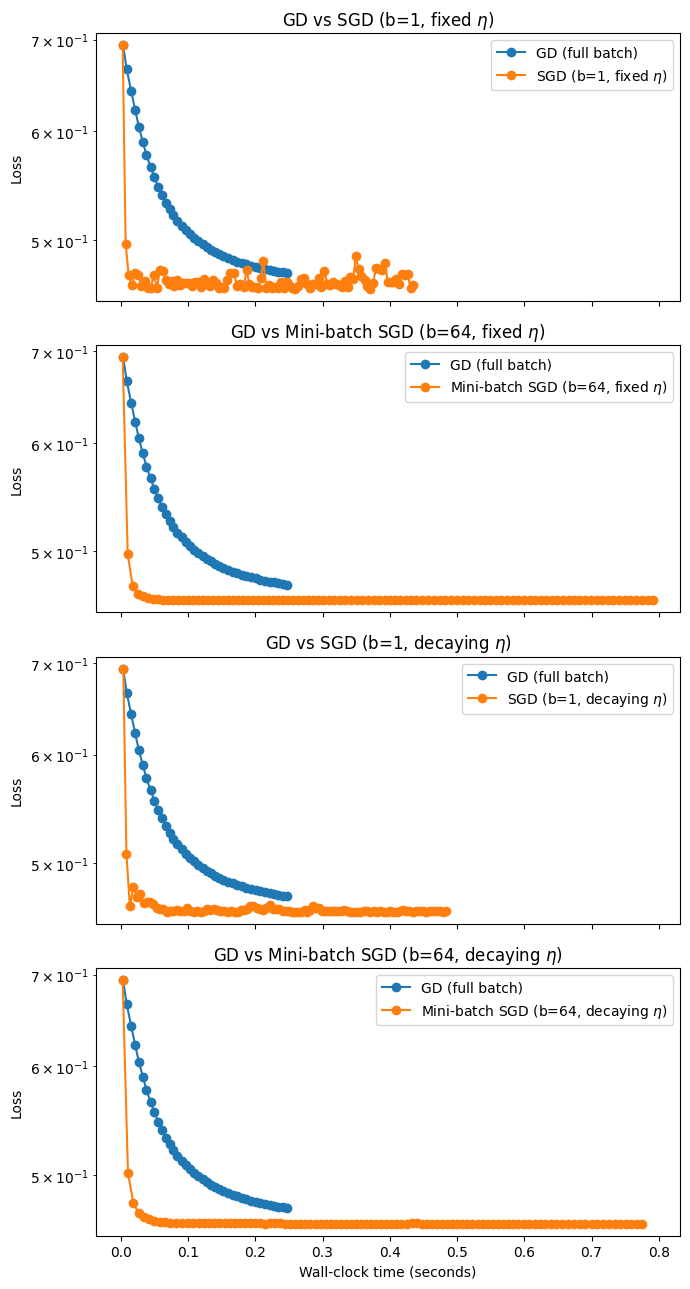

In [12]:
theta0_big = np.array([0.0, 0.0])

# Full-batch GD reference
theta_gd_big, times_gd, fvals_gd_big = run_gd_timed(theta0_big, grad_full_big, loss_big,
                                                    steps=40, lr=0.1)

# Variant 1: plain SGD (batch_size=1, fixed lr)
theta_sgd1, times_sgd1, fvals_sgd1 = run_sgd_timed(theta0_big, grad_single_big, loss_big,
                                                  n_data=N_big, steps=4000, lr=0.05,
                                                  batch_size=1, decay=False, record_every=40)

# Variant 2: mini-batch SGD (batch_size=64, fixed lr)
theta_sgd_mb, times_sgd_mb, fvals_sgd_mb = run_sgd_timed(theta0_big, grad_single_big, loss_big,
                                                       n_data=N_big, steps=4000, lr=0.05,
                                                       batch_size=64, decay=False, record_every=40)

# Variant 3: SGD with decaying lr (batch_size=1)
theta_sgd_decay, times_sgd_decay, fvals_sgd_decay = run_sgd_timed(theta0_big, grad_single_big, loss_big,
                                                                 n_data=N_big, steps=4000, lr=0.05,
                                                                 batch_size=1, decay=True, record_every=40)

# Variant 4: mini-batch SGD with decaying lr (batch_size=64)
theta_sgd_mb_decay, times_sgd_mb_decay, fvals_sgd_mb_decay = run_sgd_timed(theta0_big, grad_single_big, loss_big,
                                                                         n_data=N_big, steps=4000, lr=0.05,
                                                                         batch_size=64, decay=True, record_every=40)

print('Final GD (big) theta:', theta_gd_big, '  loss:', loss_big(theta_gd_big))
print('Final SGD-1 (big) theta:', theta_sgd1, '  loss:', loss_big(theta_sgd1))
print('Final SGD-mini-batch (big) theta:', theta_sgd_mb, '  loss:', loss_big(theta_sgd_mb))
print('Final SGD-decay (big) theta:', theta_sgd_decay, '  loss:', loss_big(theta_sgd_decay))
print('Final SGD-mini-batcj-decay (big) theta:', theta_sgd_mb_decay, '  loss:', loss_big(theta_sgd_mb_decay))

fig, axs = plt.subplots(4, 1, figsize=(7, 13), sharex=True)

# 1) GD vs plain SGD
ax = axs[0]
ax.semilogy(times_gd, fvals_gd_big, marker='o', label='GD (full batch)')
ax.semilogy(times_sgd1, fvals_sgd1, marker='o', label='SGD (b=1, fixed $\eta$)')
ax.set_ylabel('Loss')
ax.set_title('GD vs SGD (b=1, fixed $\eta$)')
ax.legend()

# 2) GD vs mini-batch SGD
ax = axs[1]
ax.semilogy(times_gd, fvals_gd_big, marker='o', label='GD (full batch)')
ax.semilogy(times_sgd_mb, fvals_sgd_mb, marker='o', label='Mini-batch SGD (b=64, fixed $\eta$)')
ax.set_ylabel('Loss')
ax.set_title('GD vs Mini-batch SGD (b=64, fixed $\eta$)')
ax.legend()

# 3) GD vs decaying-lr SGD
ax = axs[2]
ax.semilogy(times_gd, fvals_gd_big, marker='o', label='GD (full batch)')
ax.semilogy(times_sgd_decay, fvals_sgd_decay, marker='o', label='SGD (b=1, decaying $\eta$)')
ax.set_ylabel('Loss')
ax.set_title('GD vs SGD (b=1, decaying $\eta$)')
ax.legend()

# 4) GD vs mini-batch + decaying-lr SGD
ax = axs[3]
ax.semilogy(times_gd, fvals_gd_big, marker='o', label='GD (full batch)')
ax.semilogy(times_sgd_mb_decay, fvals_sgd_mb_decay, marker='o', label='Mini-batch SGD (b=64, decaying $\eta$)')
ax.set_xlabel('Wall-clock time (seconds)')
ax.set_ylabel('Loss')
ax.set_title('GD vs Mini-batch SGD (b=64, decaying $\eta$)')
ax.legend()

plt.tight_layout()
plt.show()

if nbviz_available:
    cl.nbviz.savefig('logistic_gd_vs_sgd_variants_largeN')

### Remarks and Interpretation

- In **Section B** (small $N$), GD and SGD produce similar fits and losses; the landscape
  is simple and each full gradient is cheap.
- In **Section C** (large $N$), we see that:
  - Plain SGD (batch size 1, fixed learning rate) can reduce the loss quickly but has
    noisier behavior and the final parameters can differ from GD when using a fixed step size.
  - Mini-batch SGD ($b=64$) smooths out some of the noise and can be a good compromise
    between variance and per-step cost.
  - SGD with a **decaying learning rate** moves quickly at first and then settles,
    reducing the variance of the final iterate and bringing it closer (in loss) to GD.
  - Mini-batch + decaying learning rate combines both effects and is close to what is
    used in many practical ML training setups (often plus more sophisticated schedules).

The fact that SGD-type methods can reach a loss comparable to GD, often in less wall-clock
time for large datasets (especially in efficient implementations), is the main reason they
are preferred in large-scale machine learning. Differences in the parameter vectors
$\theta$ are typically acceptable if the predictive performance (loss) is similar,
especially when the model is not exactly identifiable or the data are noisy.

The logistic example remains modular:
- To try a different model or loss, define new versions of `model`, `loss`, `grad_full`,
  and `grad_single`, then plug them into the GD/SGD runners.


## Summary: Gradient-Based Optimization Methods

| Method | How It Works | Pros | Cons | Typical Use |
|-------|--------------|------|------|--------------|
| **Full Gradient Descent (GD)** | Uses **all** data to compute each gradient step. | - Stable, smooth convergence<br>- Good for convex problems<br>- Easy to analyze theoretically | - Each step costs **O(N)**<br>- Slow when dataset is large<br>- Not scalable to modern ML datasets | Small datasets; problems where exact gradients are cheap. |
| **Stochastic Gradient Descent (SGD)** | Uses **one** randomly chosen data point per step. | - Very cheap updates (**O(1)**)<br>- Fast initial decrease in loss<br>- Can escape shallow minima in nonconvex problems | - Noisy path<br>- Does not converge to a point with fixed step size<br>- Sensitive to learning rate | Very large datasets; online learning; deep learning. |
| **Mini-batch SGD** | Uses a **small batch** of data (e.g., 32–256) per step. | - Lower variance than plain SGD<br>- Still cheaper than full GD<br>- Can leverage parallel hardware efficiently | - Still has some noise<br>- Choice of batch size affects speed & convergence | Standard method in deep learning; good speed/stability trade-off. |
| **SGD with Decaying Learning Rate** | SGD but with a step size that decreases over time. | - Fast early progress<br>- Later steps stabilize near minimum<br>- Reduces parameter variance | - Requires tuning decay schedule<br>- Slower late-stage progress | Large-scale convex optimization; improving SGD’s final accuracy. |
